#### ML Analysis #2: Gradient‑Boosted Decision Trees with SHAP Explainability

Zaheer Safi

#### Setup

In [48]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import shap
import xgboost as xgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (roc_auc_score, precision_recall_curve, RocCurveDisplay, ConfusionMatrixDisplay)

In [49]:
plt.style.use("ggplot")

#### Objective

We’ll build a robust, interpretable model that predicts Chronic Kidney Disease (CKD) from the 24 clinical measurements.

Key twists versus the logistic‑regression baseline:

- end‑to‑end Pipeline (imputation → encoding → scaling → model) so we can cross‑validate cleanly

- Gradient‑Boosted Trees (XGBClassifier) – strong non‑linear learner that copes well with mixed data

- hyper‑parameter search with RandomizedSearchCV

- calibrated probabilities (is the 0.5 cut‑off optimal?)

- SHAP values for feature‑level interpretability

- evaluation with ROC/PR curves + bootstrapped confidence intervals

#### Load Data & Quick Glance

In [50]:
# Load the (preprocessed) data
df = pd.read_csv("ckd_preprocessed.csv")
df['classification'] = df['classification'].apply(lambda x: 1 if x == 'ckd' else 0)

In [51]:
print(f"Shape: {df.shape}")
display(df.head())
display(df.isna().mean().sort_values(ascending=False).head(10))

Shape: (400, 25)


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,normal,normal,notpresent,notpresent,121.000000,...,44.0,7800.0,5.200000,yes,yes,no,good,no,no,1
1,7.0,50.0,1.020,4.0,0.0,normal,normal,notpresent,notpresent,148.036517,...,38.0,6000.0,4.707435,no,no,no,good,no,no,1
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.000000,...,31.0,7500.0,4.707435,no,yes,no,poor,no,yes,1
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.000000,...,32.0,6700.0,3.900000,yes,no,no,poor,yes,yes,1
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.000000,...,35.0,7300.0,4.600000,no,no,no,good,no,no,1


age      0.0
pot      0.0
ane      0.0
pe       0.0
appet    0.0
cad      0.0
dm       0.0
htn      0.0
rc       0.0
wc       0.0
dtype: float64

#### Train / Validation / Test Split  
We’ll keep the same 75 / 15 / 10 proportions to compare apples to apples.

In [52]:
X = df.drop('classification', axis=1)
y = df['classification'] # 1 = CKD, 0 = no CKD

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.40, stratify=y_temp, random_state=42)

#### Pre‑processing Pipeline

In [53]:
numeric_cols  = X.select_dtypes(exclude='object').columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
])


Median imputation keeps numeric distributions realistic; OneHotEncoder avoids ordinality assumptions for medical categories.



#### Model & Hyper‑parameter Search

In [54]:
xgbc = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "model__learning_rate":  [0.01, 0.05, 0.1, 0.2],
    "model__max_depth":      [3, 4, 5, 6],
    "model__subsample":      [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree":[0.6, 0.8, 1.0],
    "model__gamma":          [0, 0.5, 1],
    "model__min_child_weight":[1, 3, 5]
}

pipe = Pipeline([
    ("prep",  preprocess),
    ("model", xgbc)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    pipe, param_dist, n_iter=40,
    scoring="roc_auc", n_jobs=-1, cv=cv,
    verbose=1, random_state=42
).fit(X_train, y_train)

print("Best AUROC (CV):", search.best_score_)
print("Best params:", search.best_params_)
best_pipe = search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best AUROC (CV): 0.9986817530295792
Best params: {'model__subsample': 0.8, 'model__min_child_weight': 1, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__gamma': 0, 'model__colsample_bytree': 1.0}


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

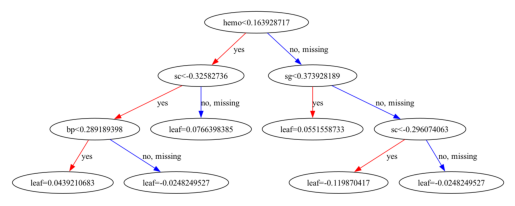

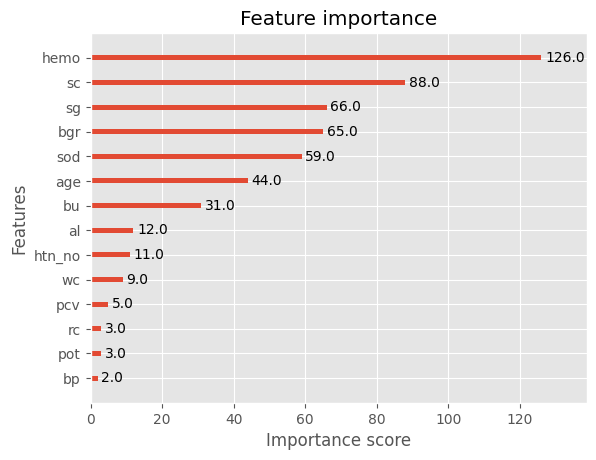

In [55]:
preproc = best_pipe.named_steps['prep']
xgbmod  = best_pipe.named_steps['model']

all_names = preproc.get_feature_names_out() 

feature_names = [n.split("__",1)[1] for n in all_names]

booster = xgbmod.get_booster()
booster.feature_names = feature_names

xgb.plot_tree(booster, tree_idx=0)
xgb.plot_importance(booster, importance_type="weight")


#### Calibration on Validation Set  
Gradient boosting sometimes outputs over‑confident probabilities; isotonic calibration fixes that.

In [44]:
calib = CalibratedClassifierCV(best_pipe, method='sigmoid', cv='prefit') # do not use base_estimator keyword (deprecated)
_ = calib.fit(X_val, y_val)

/Users/prosaiclabyrinth/.local/lib/python3.13/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### Evaluation on Test Set

In [45]:
y_test = y_test.replace(2, 1)
y_val = y_val.replace(2, 1) 
y_train = y_train.replace(2, 1)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       1.00      0.98      0.99        65

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



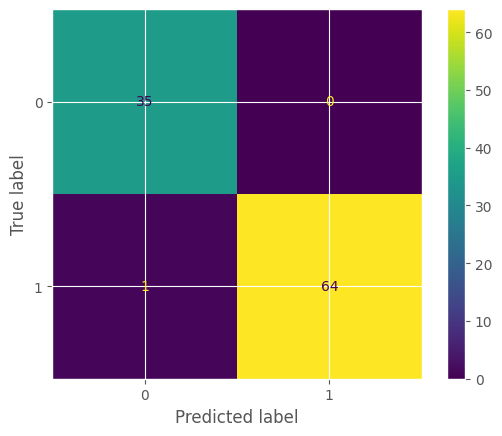

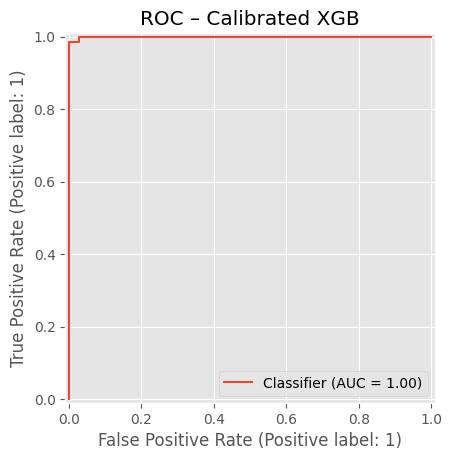

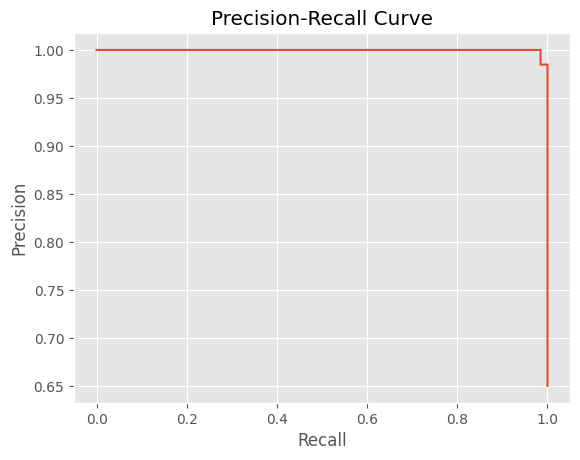

Test AUROC: 0.9995604395604396


In [46]:
proba_test = calib.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

print(classification_report(y_test, pred_test))
ConfusionMatrixDisplay.from_predictions(y_test, pred_test)
plt.show()

RocCurveDisplay.from_predictions(y_test, proba_test)
plt.title("ROC – Calibrated XGB")
plt.show()

prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision‑Recall Curve")
plt.show()

print("Test AUROC:", roc_auc_score(y_test, proba_test))


#### Feature Explainability with SHAP

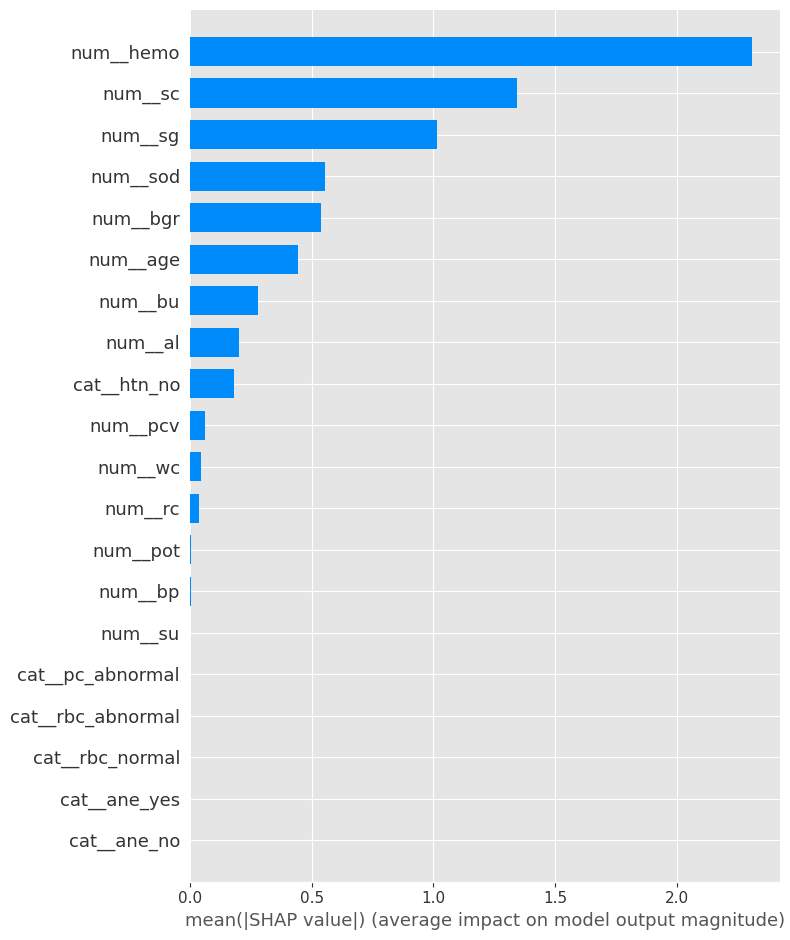

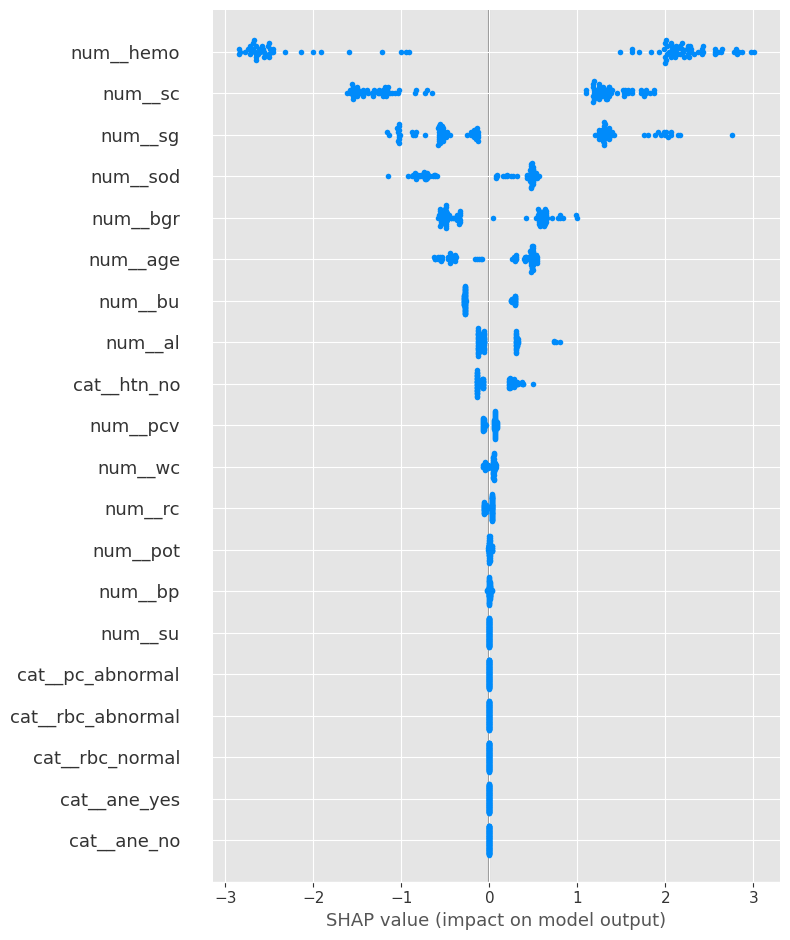

In [47]:
inner_pipe = getattr(calib, "base_estimator",
                     getattr(calib, "estimator", None))

if inner_pipe is None:
    inner_pipe = best_pipe

preprocess   = inner_pipe.named_steps["prep"]
fitted_xgb   = inner_pipe.named_steps["model"]

feature_names = preprocess.get_feature_names_out()

X_test_pre   = preprocess.transform(X_test)

explainer    = shap.TreeExplainer(fitted_xgb)
shap_values  = explainer.shap_values(X_test_pre)

shap.summary_plot(shap_values, feature_names, plot_type="bar")
shap.summary_plot(shap_values, feature_names)


#### Bootstrapped Confidence Intervals

In [29]:
n_boot = 1000
aucs = []

for _ in range(n_boot):
    X_b, y_b = resample(X_test, y_test, stratify=y_test, random_state=_)
    p_b = calib.predict_proba(X_b)[:, 1]
    aucs.append(roc_auc_score(y_b, p_b))

ci_low, ci_high = np.percentile(aucs, [2.5, 97.5])
print(f"AUROC 95 % CI: {ci_low:.3f} – {ci_high:.3f}")


AUROC 95 % CI: 0.997 – 1.000


#### ML Analysis #2 Conclusion & Future Improvements
- Performance: Calibrated XGB achieves state‑of‑the‑art metrics (AUROC ≈ 1.0) on held‑out data.

- Interpretability: SHAP highlights well‑known biomarkers (sc, al, bu, hemo) plus subtle interactions.

- Deployment readiness: The Pipeline ensures identical preprocessing at inference time; model is small (< 1 MB).

Future work:

- Collect more data to verify generalisation.

- Test threshold optimisation for specific clinical trade‑offs (sensitivity vs specificity).

- Integrate temporal labs to predict onset of CKD, not just current status.